In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import os
import re
import sys
import h5py
import pyBigWig
import torch
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from scipy.stats import binned_statistic
from typing import Union, Optional
from torch.utils.data import Dataset, DataLoader
from torchmetrics import PearsonCorrCoef

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_job_folder, get_bioqueue_job_info, get_bioqueue_file

In [4]:
def transform_counts(values: torch.Tensor, inject_random_noise: float = 10e-16, method: str = "log1p", clamp: float = 1e-4) -> torch.Tensor:
    """
    Get asinh/log- transformed counts

    Parameters
    ----------
    values : torch.Tensor
        Values to be transformed
    inject_random_noise : float
        Scale of the random noise to be injected. If you just want to do asinh transformation, set this as 0.
    method : str
        Transformation method. Can be 'asinh' or 'log1p'
    clamp : float
        Clamp values smaller than this one as 0.

    Returns
    -------
    transformed_values: torch.Tensor
        The same shape as `values`
    """
    noises = torch.randn_like(values, device=values.device) * inject_random_noise
    func = torch.asinh if method == "asinh" else torch.log1p
    values = torch.where(values>clamp, values, 0.)
    return func(values) + noises

In [ ]:
class EvaluationDataset(Dataset):
    def __init__(self, pl_pred_bw_file: str, pl_obs_bw_file: str, peak_file: Union[str, pd.DataFrame], 
                 mn_pred_bw_file: Optional[str] = None, mn_obs_bw_file: Optional[str] = None, bin_size: int = 1, 
                 unified_len_def: int = 1000, bin_stat: str = "mean", all_regions: bool = False):
        """

        Parameters
        ----------
        pl_pred_bw_file : str
            Path to the bigwig storing predictions for the forward strand
        pl_obs_bw_file : str
            Path to the bigwig storing ground-truth for the forward strand
        peak_file : str
            Path to a headless-csv file storing the regions of interest
        mn_pred_bw_file : str
            Path to the bigwig storing predictions for the reverse strand
        mn_obs_bw_file : str
            Path to the bigwig storing ground-truth for the reverse strand
        bin_size : int
            1 for no binning
        unified_len_def : int
            Extend/shrink the spans of the regions to this length
        bin_stat : str
            only effective when bin_size > 1
        all_regions : bool
            
        """
        if any([not os.path.exists(f) for f in (
                pl_pred_bw_file, pl_obs_bw_file)]):
            raise IOError()
        self.pl_pred_bw = pyBigWig.open(pl_pred_bw_file)
        self.pl_obs_bw = pyBigWig.open(pl_obs_bw_file)
        self._in_files = [pl_pred_bw_file, pl_obs_bw_file, mn_pred_bw_file, mn_obs_bw_file]
        
        if all([f is not None and os.path.exists(f) for f in (
                mn_pred_bw_file, mn_obs_bw_file)]):
            self.mn_pred_bw = pyBigWig.open(mn_pred_bw_file)
            self.mn_obs_bw = pyBigWig.open(mn_obs_bw_file)
        else:
            self.mn_pred_bw = None
            self.mn_obs_bw = None
            print("No signal tracks for the reverse strands.")

        if isinstance(peak_file, str):
            self.regions = pd.read_csv(peak_file, header=None, comment="#")
        else:
            self.regions = peak_file.copy() 
        if not all_regions:
            self.regions = self.regions.loc[self.regions[3] == 1].reset_index(drop=True)
        allowed_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", ]
        self.regions = self.regions.loc[self.regions[0].isin(allowed_chroms)].reset_index(drop=True)

        half = unified_len_def // 2
        mids = (self.regions[1] + self.regions[2]) // 2
        self.regions[1] = mids - half
        self.regions[2] = mids + half

        self.truncation_for_bin = int((unified_len_def % bin_size) // 2)
        self.n_bins = int(unified_len_def // bin_size)
        self.bin_x = np.arange(self.n_bins * bin_size)
        self.bin_stat = bin_stat
        self._warns = 0

    def __len__(self):
        return self.regions.shape[0]

    def bw_retriever(self, bw_in, chrom, start, end, bw_idx = None):
        try:
            return np.abs(np.nan_to_num(bw_in.values(chrom, start, end)))
        except Exception:
            if bw_idx is not None:
                bw_info = self._in_files[bw_idx]
            else:
                bw_info = str(bw_in)
            self._warns += 1
            if self._warns < 3:
                print(f"Warning: No values stored in {bw_info} for region {chrom}:{start}-{end}")
            return np.zeros(end - start)

    def __getitem__(self, idx: int):
        try:
            y_hats = []
            y = []
            have_mn = False
            hit = self.regions.iloc[idx]
            y_hat_pl = self.bw_retriever(self.pl_pred_bw, hit[0], hit[1], hit[2], 0)
            y_pl = self.bw_retriever(self.pl_obs_bw, hit[0], hit[1], hit[2], 1)

            if self.mn_pred_bw is not None and self.mn_obs_bw is not None:
                y_hat_mn = self.bw_retriever(self.mn_pred_bw, hit[0], hit[1], hit[2], 2)
                y_mn = self.bw_retriever(self.mn_obs_bw, hit[0], hit[1], hit[2], 3)
                have_mn = True

            if self.truncation_for_bin > 0:
                y_hat_pl = binned_statistic(self.bin_x, y_hat_pl[self.truncation_for_bin:-self.truncation_for_bin], 
                                            statistic=self.bin_stat, bins=self.n_bins)[0]
                y_pl = binned_statistic(self.bin_x, y_pl[self.truncation_for_bin:-self.truncation_for_bin], 
                                        statistic=self.bin_stat, bins=self.n_bins)[0]
                
                if self.mn_pred_bw is not None and self.mn_obs_bw is not None:
                    y_hat_mn = binned_statistic(self.bin_x, y_hat_mn[self.truncation_for_bin:-self.truncation_for_bin], 
                                                statistic=self.bin_stat, bins=self.n_bins)[0]
                    y_mn = binned_statistic(self.bin_x, y_mn[self.truncation_for_bin:-self.truncation_for_bin], 
                                            statistic=self.bin_stat, bins=self.n_bins)[0]
            y_hats.append(y_hat_pl)
            y.append(y_pl)

            if have_mn:
                y_hats.append(y_hat_mn)
                y.append(y_mn)
        except Exception as e:
            print(hit, self._in_files)
            raise e

        return torch.from_numpy(np.stack(y_hats)), torch.from_numpy(np.stack(y))
    def close_files(self):
        self.pl_pred_bw.close()
        self.pl_obs_bw.close()
        if self.mn_pred_bw is not None:
            self.mn_pred_bw.close()
        if self.mn_obs_bw is not None:
            self.mn_obs_bw.close()

In [6]:
def get_ref_files(lst, pattern):
    matches = []
    for item in lst:
        match = re.match(pattern, item)
        if match:
            group1 = match.group(1)
            group2 = match.group(2)
            job_folder = get_bioqueue_job_folder(group1)
            job_file = os.path.join(job_folder, group2)
            if not os.path.exists(job_file):
                raise IOError(f"{job_file} doesn't exist!")
            matches.append(job_file)
        else:
            raise ValueError(f"{item} doesn't match the expected pattern.")
    return matches

In [ ]:
def evaluate_corr(
    peak_file: Union[str, pd.DataFrame],
    r1_pl: str,
    r1_mn: str,
    r2_pl: str,
    r2_mn: str,
    assay_name: str,
    cellline_name: str,
    eval_label: str,
    bin_size: int = 128,
    all_regions: bool = False,
    transformation: str = "log1p",
) -> tuple[str, str, str, float, float]:
    """
    Compute counts- and shape-level Pearson correlations for a single evaluation setup.

    Parameters
    ----------
    peak_file : str or pandas.DataFrame
        Regions of interest, either as a path to a peak file or an in-memory
        dataframe.
    r1_pl : str
        Path to the bigwig file with predicted signal on the forward strand.
    r1_mn : str
        Path to the bigwig file with predicted signal on the reverse strand.
    r2_pl : str
        Path to the bigwig file with observed signal on the forward strand.
    r2_mn : str
        Path to the bigwig file with observed signal on the reverse strand.
    assay_name : str
        Name of the assay; returned as metadata.
    cellline_name : str
        Name of the cell line; returned as metadata.
    eval_label : str
        Label describing this evaluation (e.g. split or condition); returned as metadata.
    bin_size : int, optional
        Bin size used by the evaluation dataset. Default is 128.
    all_regions : bool, optional
        Whether to include all regions. Default is False (no background regions).
    transformation : str, optional
        Name of the transformation method passed to `transform_counts`.
        Default is `log1p`.

    Returns
    -------
    assay_name : str
        The input assay name.
    eval_label : str
        The input evaluation label.
    cellline_name : str
        The input cell line name.
    counts_corr : float
        Counts-level Pearson correlation across all regions.
    shape_corr : float
        Shape-level Pearson correlation across all regions.
    """
    eds = EvaluationDataset(
        pl_pred_bw_file=r1_pl, mn_pred_bw_file=r1_mn, 
        pl_obs_bw_file=r2_pl, mn_obs_bw_file=r2_mn, 
        peak_file=peak_file, bin_size=bin_size, all_regions=all_regions)
    
    _iter = DataLoader(eds, batch_size=32, shuffle=False, num_workers=0)
    counts_metric = PearsonCorrCoef()
    shape_metric = PearsonCorrCoef()

    for ds in _iter:
        # shape
        y_hat = ds[0]
        y = ds[1]
        shape_metric(
            transform_counts(y_hat.flatten(), method=transformation),
            transform_counts(y.flatten(), method=transformation)
        )
        
        # counts: sum over the strands and bps
        y_hat = ds[0].sum(axis=-1).sum(axis=-1)
        y = ds[1].sum(axis=-1).sum(axis=-1)
        counts_metric(
            transform_counts(y_hat, method=transformation),
            transform_counts(y, method=transformation)
        )
    eds.close_files()
    return (assay_name, eval_label, cellline_name, counts_metric.compute().item(), shape_metric.compute().item())

In [9]:
cor_records = []

# Get reference lines

In [10]:
ref_lines = []

### Initiation

In [11]:
initiation_region_file_job_mapping = {
    "K562": 7177, 
    "A673": 7177, 
    "HCT116": 7177, 
    "HUVEC": 7177, 
    "MCF10A": 7177, 
    "Caco2": 7178, 
    "Calu3": 7178, 
    "GM12878": 7178, 
    "LNCaP": 7178, 
    "MCF7": 7178,
}

### Pause-release

In [12]:
pr_region_file_job_mapping = {
    "K562": 7177, 
    "A673": 14014, 
    "HCT116": 15190, 
    "HUVEC": 14014, 
    "MCF10A": 14014, 
    "Caco2": 14014, 
    "Calu3": 15190, 
    "LNCaP": 14014, 
    "MCF7": 7178,
}

### Histone marks

In [13]:
hst_region_file_job_mapping = {
    "Caco2_K4m1": 13985, 
    "H9_K4m1": 13985, 
    "HCT116_K4m1": 13985, 
    "MCF10A_K4m1": 13985, 
    "Caco2_K4m3": 13983, 
    "H9_K4m3": 13983, 
    "HCT116_K4m3": 13983, 
    "MCF10A_K4m3": 13983, 
    "K562_K27ac": 13980, 
    "GM12878_K27ac": 13980, 
    "HUVEC_K27ac": 13980, 
    "HepG2_K27ac": 13980, 
    "HCT116_K27ac": 13980, 
}

## Expectation bound

### Initiation

SOTA for this task: Puffin-D

In [14]:
puffind_5d_job_mapping = {
    "K562": 14082, 
    "A673": 14082, 
    "HCT116": 14082, 
    "HUVEC": 14082, 
    "MCF10A": 14082, 
    "Caco2": 14102, 
    "Calu3": 14102, 
    "GM12878": 14102, 
    "LNCaP": 14102, 
    "MCF7": 14102,
}

In [15]:
_jobs = []
_ref_file_pattern = r"^{{History:(\d+)-(.*\.bw)}}$"

for cl, jid in puffind_5d_job_mapping.items():
    job_info = get_bioqueue_job_info(jid)
    job_folder = os.path.join(job_info["run_dir"], str(job_info["user_id"]), job_info["result"])
    pars = {g.split("=")[0]: g.split("=")[1].split(" ") for g in job_info["parameter"].split(";") if len(g) > 0}

    pl_ref_hits = list(filter(lambda s: cl in s, pars["Pls"]))
    mn_ref_hits = list(filter(lambda s: cl in s, pars["Mns"]))
    assert len(pl_ref_hits) == len(mn_ref_hits) == 1
    
    ref_files = [pl_ref_hits[0], mn_ref_hits[0]]
    
    abs_ref_files = get_ref_files(ref_files, _ref_file_pattern)
    
    pl_pred_file = os.path.join(job_folder, f"{cl}.pl.bw")
    mn_pred_file = os.path.join(job_folder, f"{cl}.mn.bw")
    
    sim_job_info = get_bioqueue_job_info(initiation_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Initiation", cl, "Supervised learning", 128, False))
    
with Pool(16) as pool:
    init_sup_sota_cors = pool.starmap(evaluate_corr, _jobs)
ref_lines.extend(init_sup_sota_cors)

In [16]:
pd.DataFrame(init_sup_sota_cors)

,0,1,2,3,4
0,Initiation,Supervised learning,K562,0.689760,0.656596
1,Initiation,Supervised learning,A673,0.783671,0.743107
2,Initiation,Supervised learning,HCT116,0.774925,0.740960
3,Initiation,Supervised learning,HUVEC,0.792844,0.752583
4,Initiation,Supervised learning,MCF10A,0.777026,0.726048
5,Initiation,Supervised learning,Caco2,0.790818,0.741806
6,Initiation,Supervised learning,Calu3,0.770332,0.726884
7,Initiation,Supervised learning,GM12878,0.743443,0.701358
8,Initiation,Supervised learning,LNCaP,0.754939,0.714216
9,Initiation,Supervised learning,MCF7,0.760306,0.704666


### Pause-release
SOTA for this task: Puffin-D

In [ ]:
# 15123: A673 Caco2 HUVEC LNCaP MCF10A
# 15191: A673 Calu3 HCT116 HUVEC LNCaP
puffind_pausing_job_mapping = {
    "A673": 15123, 
    "HCT116": 15191, 
    "HUVEC": 15123, 
    "MCF10A": 15123, 
    "Caco2": 15123, 
    "Calu3": 15191, 
    "LNCaP": 15123, 
    "LNCaP|2": 15191, 
    "HUVEC|2": 15191, 
}

In [18]:
_jobs = []
_ref_file_pattern = r"^{{History:(\d+)-(.*\.bw)}}$"

for cl, jid in puffind_pausing_job_mapping.items():
    cl = cl.split("|")[0]
    job_info = get_bioqueue_job_info(jid)
    job_folder = os.path.join(job_info["run_dir"], str(job_info["user_id"]), job_info["result"])
    pars = {g.split("=")[0]: g.split("=")[1].split(" ") for g in job_info["parameter"].split(";") if len(g) > 0}

    pl_ref_hits = list(filter(lambda s: cl in s, pars["Pls"]))
    mn_ref_hits = list(filter(lambda s: cl in s, pars["Mns"]))
    assert len(pl_ref_hits) == len(mn_ref_hits) == 1
    
    ref_files = [pl_ref_hits[0], mn_ref_hits[0]]
    
    abs_ref_files = get_ref_files(ref_files, _ref_file_pattern)
    
    pl_pred_file = os.path.join(job_folder, f"{cl}.pl.bw")
    mn_pred_file = os.path.join(job_folder, f"{cl}.mn.bw")
    
    sim_job_info = get_bioqueue_job_info(initiation_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Pause-release", cl, "Supervised learning", 128, False))
    
with Pool(16) as pool:
    pr_sup_sota_cors = pool.starmap(evaluate_corr, _jobs)
ref_lines.extend(pr_sup_sota_cors)

In [19]:
pd.DataFrame(pr_sup_sota_cors)

,0,1,2,3,4
0,Pause-release,Supervised learning,A673,0.775170,0.731902
1,Pause-release,Supervised learning,HCT116,0.802766,0.775636
2,Pause-release,Supervised learning,HUVEC,0.788097,0.747000
3,Pause-release,Supervised learning,MCF10A,0.769243,0.720162
4,Pause-release,Supervised learning,Caco2,0.783446,0.734336
5,Pause-release,Supervised learning,Calu3,0.781844,0.739227
6,Pause-release,Supervised learning,LNCaP,0.752519,0.703715
7,Pause-release,Supervised learning,LNCaP,0.753908,0.706238
8,Pause-release,Supervised learning,HUVEC,0.783520,0.744775


### Histone modification
SOTA for this task: Enformer

Preprocessing steps: [SupervisedSignalPrediction/Enformer/get_data.sh](https://git.yaobio.com/RunOnDeconvolution/pipeline-helpers/src/branch/main/SupervisedSignalPrediction/Enformer/get_data.sh) and [SupervisedSignalPrediction/Enformer/get_inputs_for_evaluation.py](https://git.yaobio.com/RunOnDeconvolution/pipeline-helpers/src/branch/main/SupervisedSignalPrediction/Enformer/get_inputs_for_evaluation.py)

In [ ]:
enformer_prediciton_targets = pd.read_csv("../../Data/Preds/Enformer/targets.txt", sep="\t")
to_keep_index = [
    688, 705, 1379, 3485,  # K27ac
    1126, 3667, 1173, 2467,  # K4me3
]
enformer_histone_chips = enformer_prediciton_targets.iloc[to_keep_index]
enformer_histone_chips.head()

,index,genome,identifier,file,clip,scale,sum_stat,description
688,688,0,ENCFF340JIF,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27ac:GM12878
705,705,0,ENCFF656TFQ,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27ac:endothelial cell of umbilical vei...
1379,1379,0,ENCFF329BPA,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27ac:HCT116
3485,3485,0,ENCFF984WLE,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27ac:HCT116
1126,1126,0,ENCFF109LUV,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K4me3:Caco-2


In [21]:
enformer_histone_chips_meta = enformer_histone_chips.description.str.split(":", expand=True).sort_index()
enformer_histone_chips_meta.head()

,0,1,2
688,CHIP,H3K27ac,GM12878
705,CHIP,H3K27ac,endothelial cell of umbilical vein male newborn
1126,CHIP,H3K4me3,Caco-2
1173,CHIP,H3K4me3,HCT116
1379,CHIP,H3K27ac,HCT116


In [22]:
enformer_regions = pd.read_csv("../../Data/Preds/Enformer/sequences.bed", sep="\t", header=None)
enformer_test_regions = enformer_regions.loc[enformer_regions[3]=="test", :].copy().reset_index(drop=True)
enformer_test_regions.head()

,0,1,2,3
0,chr10,37555537,37686609,test
1,chr14,87048845,87179917,test
2,chrX,136527085,136658157,test
3,chr11,34042349,34173421,test
4,chr19,10352757,10483829,test


In [23]:
with h5py.File("../../Data/Preds/Enformer/predictions.h5") as enformer_h5:
    print(enformer_h5.keys())
    enformer_preds = enformer_h5["preds"]
    enformer_targets = enformer_h5["truth"]
    print(enformer_preds.shape)
    print(enformer_preds[0, :, sorted(enformer_histone_chips["index"].values)].shape)

<KeysViewHDF5 ['preds', 'truth']>
(1937, 896, 5313)
(896, 8)


In [ ]:
class EvaluationDatasetHDF5(Dataset):
    def __init__(self, h5_file, selected_targets: list[int] = None):
        """

        Parameters
        ----------
        h5_file : str
            Path to the bigwig storing predictions for the forward strand
        selected_targets : optional, list[int]
            Indexes of the prediction targets of interest
        """
        if not os.path.exists(h5_file):
            raise IOError()
        self.enformer_h5 = h5py.File(h5_file)
        
        self.enformer_preds = self.enformer_h5["preds"]
        self.enformer_targets = self.enformer_h5["truth"]
        self.selected_targets = sorted(selected_targets)

        assert self.enformer_preds.shape[0] == self.enformer_targets.shape[0]

    def __len__(self):
        return self.enformer_preds.shape[0]

    def __getitem__(self, idx: int):
        if self.selected_targets is not None:
            return torch.from_numpy(self.enformer_preds[idx, :, self.selected_targets]), torch.from_numpy(self.enformer_targets[idx, :, self.selected_targets])
        else:
            return torch.from_numpy(self.enformer_preds[idx, :, :]), torch.from_numpy(self.enformer_targets[idx, :, :])

In [25]:
histone_indexes = enformer_histone_chips.index.values
evd = EvaluationDatasetHDF5("../../Data/Preds/Enformer/predictions.h5", histone_indexes)

In [26]:
_iter = DataLoader(evd, batch_size=32, shuffle=False, num_workers=0)
counts_metric = PearsonCorrCoef(num_outputs=len(histone_indexes))
shape_metric = PearsonCorrCoef(num_outputs=len(histone_indexes))
transformation = "log1p"

for ds in _iter:
    # shape
    y_hat = ds[0].view(-1, ds[0].shape[-1])
    y = ds[1].view(-1, ds[0].shape[-1])
    shape_corr = shape_metric(
        transform_counts(y_hat, method=transformation),
        transform_counts(y, method=transformation)
    )
    
    # counts: sum over the bins
    y_hat = ds[0].sum(axis=1)
    y = ds[1].sum(axis=1)
    counts_corr = counts_metric(
        transform_counts(y_hat, method=transformation),
        transform_counts(y, method=transformation)
    )
shape_corr = shape_metric.compute()

counts_corr = counts_metric.compute()

In [ ]:
for ccs, scs, cellline_name in zip(counts_corr, shape_corr, enformer_histone_chips_meta[2].values):
    ref_lines.append(("Histone modification", "Supervised learning", cellline_name, ccs.item(), scs.item()))

# Prediction

## Fused model
### Initiation

In [28]:
deepdetails_5d_job_mapping = {
    "5D1_A673_Initiation": (
        get_bioqueue_file("{{History:18304-a673.pl.bw}}"),
        get_bioqueue_file("{{History:18304-a673.mn.bw}}")
    ),
    "5D1_HCT116_Initiation": (
        get_bioqueue_file("{{History:18304-hct116.pl.bw}}"),
        get_bioqueue_file("{{History:18304-hct116.mn.bw}}")
    ),
    "5D1_HUVEC_Initiation": (
        get_bioqueue_file("{{History:18304-huvec.pl.bw}}"),
        get_bioqueue_file("{{History:18304-huvec.mn.bw}}")
    ),
    "5D1_K562_Initiation": (
        get_bioqueue_file("{{History:18304-k562.pl.bw}}"),
        get_bioqueue_file("{{History:18304-k562.mn.bw}}")
    ),
    "5D1_MCF10A_Initiation": (
        get_bioqueue_file("{{History:18304-mcf10a.pl.bw}}"),
        get_bioqueue_file("{{History:18304-mcf10a.mn.bw}}")
    ),
    "5D2_Caco2_Initiation": (
        get_bioqueue_file("{{History:18305-caco2.pl.bw}}"),
        get_bioqueue_file("{{History:18305-caco2.mn.bw}}")
    ),
    "5D2_Calu3_Initiation": (
        get_bioqueue_file("{{History:18305-calu3.pl.bw}}"),
        get_bioqueue_file("{{History:18305-calu3.mn.bw}}")
    ),
    "5D2_GM12878_Initiation": (
        get_bioqueue_file("{{History:18305-gm12878.pl.bw}}"),
        get_bioqueue_file("{{History:18305-gm12878.mn.bw}}")
    ),
    "5D2_LNCaP_Initiation": (
        get_bioqueue_file("{{History:18305-lncap.pl.bw}}"),
        get_bioqueue_file("{{History:18305-lncap.mn.bw}}")
    ),
    "5D2_MCF7_Initiation": (
        get_bioqueue_file("{{History:18305-mcf7.pl.bw}}"),
        get_bioqueue_file("{{History:18305-mcf7.mn.bw}}")
    ),
}

In [29]:
pred_eval_rows = []
_jobs = []
for conf, pred_files in deepdetails_5d_job_mapping.items():
    sim_group, cl, data_type = conf.split("_")

    pl_pred_file = pred_files[0]
    mn_pred_file = pred_files[1]
    
    sim_job_info = get_bioqueue_job_info(initiation_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    abs_ref_files = [os.path.join(sim_job_folder, f"{cl}.ds.pl.bw"), os.path.join(sim_job_folder, f"{cl}.ds.mn.bw")]
    assert all([os.path.exists(f) for f in (peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1])])
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Initiation", cl, "DETAILS", 128, False))
    
with Pool(16) as pool:
    init_details_cors = pool.starmap(evaluate_corr, _jobs)
pred_eval_rows.extend(init_details_cors)

In [30]:
pred_eval_rows

[('Initiation', 'DETAILS', 'A673', 0.7850097417831421, 0.7050097584724426),
 ('Initiation', 'DETAILS', 'HCT116', 0.8478662371635437, 0.7669039368629456),
 ('Initiation', 'DETAILS', 'HUVEC', 0.8068294525146484, 0.719836950302124),
 ('Initiation', 'DETAILS', 'K562', 0.7567012310028076, 0.6416794657707214),
 ('Initiation', 'DETAILS', 'MCF10A', 0.8173847794532776, 0.7137237787246704),
 ('Initiation', 'DETAILS', 'Caco2', 0.8347636461257935, 0.748948872089386),
 ('Initiation', 'DETAILS', 'Calu3', 0.8044248223304749, 0.7127071022987366),
 ('Initiation', 'DETAILS', 'GM12878', 0.771834671497345, 0.6545460820198059),
 ('Initiation', 'DETAILS', 'LNCaP', 0.7506354451179504, 0.6456868052482605),
 ('Initiation', 'DETAILS', 'MCF7', 0.7900212407112122, 0.7036003470420837)]

In [31]:
pred_eval_dfs = []

### Pause-release

In [32]:
deepdetails_5d_job_mapping = {
    "5D3_A673_Pause-release": (
        get_bioqueue_file("{{History:18300-a673.pl.bw}}"),
        get_bioqueue_file("{{History:18300-a673.mn.bw}}")
    ),
    "5D3_Caco2_Pause-release": (
        get_bioqueue_file("{{History:18300-caco2.pl.bw}}"),
        get_bioqueue_file("{{History:18300-caco2.mn.bw}}")
    ),
    "5D3_HUVEC_Pause-release": (
        get_bioqueue_file("{{History:18300-huvec.pl.bw}}"),
        get_bioqueue_file("{{History:18300-huvec.mn.bw}}")
    ),
    "5D3_LNCaP_Pause-release": (
        get_bioqueue_file("{{History:18300-lncap.pl.bw}}"),
        get_bioqueue_file("{{History:18300-lncap.mn.bw}}")
    ),
    "5D3_MCF10A_Pause-release": (
        get_bioqueue_file("{{History:18300-mcf10a.pl.bw}}"),
        get_bioqueue_file("{{History:18300-mcf10a.mn.bw}}")
    ),
    "5D4_A673_Pause-release": (
        get_bioqueue_file("{{History:18301-a673.pl.bw}}"),
        get_bioqueue_file("{{History:18301-a673.mn.bw}}")
    ),
    "5D4_Calu3_Pause-release": (
        get_bioqueue_file("{{History:18301-calu3.pl.bw}}"),
        get_bioqueue_file("{{History:18301-calu3.mn.bw}}")
    ),
    "5D4_HCT116_Pause-release": (
        get_bioqueue_file("{{History:18301-hct116.pl.bw}}"),
        get_bioqueue_file("{{History:18301-hct116.mn.bw}}")
    ),
    "5D4_HUVEC_Pause-release": (
        get_bioqueue_file("{{History:18301-huvec.pl.bw}}"),
        get_bioqueue_file("{{History:18301-huvec.mn.bw}}")
    ),
    "5D4_LNCaP_Pause-release": (
        get_bioqueue_file("{{History:18301-lncap.pl.bw}}"),
        get_bioqueue_file("{{History:18301-lncap.mn.bw}}")
    ),
}

In [33]:
_jobs = []
for conf, pred_files in deepdetails_5d_job_mapping.items():
    sim_group, cl, data_type = conf.split("_")

    pl_pred_file = pred_files[0]
    mn_pred_file = pred_files[1]
    
    sim_job_info = get_bioqueue_job_info(pr_region_file_job_mapping[cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    abs_ref_files = [os.path.join(sim_job_folder, f"{cl}.ds.pl.bw"), os.path.join(sim_job_folder, f"{cl}.ds.mn.bw")]
    assert all([os.path.exists(f) for f in (peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1])])
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Pause-release", cl, "DETAILS", 128, False))
    
with Pool(16) as pool:
    pr_details_cors = pool.starmap(evaluate_corr, _jobs)
pred_eval_rows.extend(pr_details_cors)

### Histone modification

In [34]:
deepdetails_5d_job_mapping = {
    "KGHHH-H3K27ac_K562_Histone modification": (
        get_bioqueue_file("{{History:18302-k562.pl.bw}}"),
        get_bioqueue_file("{{History:18302-k562.mn.bw}}")
    ),
    "KGHHH-H3K27ac_GM12878_Histone modification": (
        get_bioqueue_file("{{History:18302-gm12878.pl.bw}}"),
        get_bioqueue_file("{{History:18302-gm12878.mn.bw}}")
    ),
    "KGHHH-H3K27ac_HUVEC_Histone modification": (
        get_bioqueue_file("{{History:18302-huvec.pl.bw}}"),
        get_bioqueue_file("{{History:18302-huvec.mn.bw}}")
    ),
    "KGHHH-H3K27ac_HepG2_Histone modification": (
        get_bioqueue_file("{{History:18302-hepg2.pl.bw}}"),
        get_bioqueue_file("{{History:18302-hepg2.mn.bw}}")
    ),
    "KGHHH-H3K27ac_HCT116_Histone modification": (
        get_bioqueue_file("{{History:18302-hct116.pl.bw}}"),
        get_bioqueue_file("{{History:18302-hct116.mn.bw}}")
    ),
    "CCHHM-H3K4me3_Caco2_Histone modification": (
        get_bioqueue_file("{{History:18303-caco2.pl.bw}}"),
        get_bioqueue_file("{{History:18303-caco2.mn.bw}}")
    ),
    "CCHHM-H3K4me3_Calu3_Histone modification": (
        get_bioqueue_file("{{History:18303-calu3.pl.bw}}"),
        get_bioqueue_file("{{History:18303-calu3.mn.bw}}")
    ),
    "CCHHM-H3K4me3_H9_Histone modification": (
        get_bioqueue_file("{{History:18303-h9.pl.bw}}"),
        get_bioqueue_file("{{History:18303-h9.mn.bw}}")
    ),
    "CCHHM-H3K4me3_HCT116_Histone modification": (
        get_bioqueue_file("{{History:18303-hct116.pl.bw}}"),
        get_bioqueue_file("{{History:18303-hct116.mn.bw}}")
    ),
    "CCHHM-H3K4me3_MCF10A_Histone modification": (
        get_bioqueue_file("{{History:18303-mcf10a.pl.bw}}"),
        get_bioqueue_file("{{History:18303-mcf10a.mn.bw}}")
    ),
}
hist_region_file_job_mapping = {
    "KGHHH-H3K27ac":
    {
        "K562": 13980, 
        "GM12878": 13980, 
        "HUVEC": 13980, 
        "HepG2": 13980, 
        "HCT116": 13980, 
    },
    "CCHHM-H3K4me3":
    {
        "Caco2": 13983, 
        "Calu3": 13983, 
        "H9": 13983, 
        "HCT116": 13983, 
        "MCF10A": 13983, 
    },
}

In [35]:
_jobs = []
for conf, pred_files in deepdetails_5d_job_mapping.items():
    sim_group, cl, data_type = conf.split("_")

    pl_pred_file = pred_files[0]
    mn_pred_file = pred_files[1]
    
    sim_job_info = get_bioqueue_job_info(hist_region_file_job_mapping[sim_group][cl])
    sim_job_folder = os.path.join(
        sim_job_info["run_dir"], 
        str(sim_job_info["user_id"]), 
        sim_job_info["result"])
    
    peak_file = os.path.join(sim_job_folder, "regions.csv")
    abs_ref_files = [os.path.join(sim_job_folder, f"{cl}.ds.pl.bw"), os.path.join(sim_job_folder, f"{cl}.ds.mn.bw")]
    assert all([os.path.exists(f) for f in (peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1])])
    _jobs.append((peak_file, pl_pred_file, mn_pred_file, abs_ref_files[0], abs_ref_files[1], "Histone modification", cl, "DETAILS", 128, False))
    
with Pool(16) as pool:
    hm_details_cors = pool.starmap(evaluate_corr, _jobs)
pred_eval_rows.extend(hm_details_cors)

# Summary

In [ ]:
ref_df = pd.DataFrame(ref_lines)[[0, 1, 4]]
ref_df.columns = ("data type", "ref type", "Corr coef")
# ref_df.to_csv("../../Data/Results/SupervisedBaseline.csv")
ref_df.head()

,data type,ref type,Corr coef
0,Initiation,Supervised learning,0.656596
1,Initiation,Supervised learning,0.743107
2,Initiation,Supervised learning,0.740960
3,Initiation,Supervised learning,0.752583
4,Initiation,Supervised learning,0.726048


In [37]:
eval_df = pd.DataFrame(pred_eval_rows)#[[0, 1, 4]]
cols = ["data type", "method", "cell line", ] + [r"Overall counts $r$", "Overall", ]
eval_df.columns = cols
eval_df.drop(columns=[r"Overall counts $r$"], inplace=True)
# eval_df.columns = ("data type", "ref type", "Corr coef")
# eval_df.to_csv("../../Data/Results/Eval.Sup.128.csv")
eval_df.head()

,data type,method,cell line,Overall
0,Initiation,DETAILS,A673,0.705010
1,Initiation,DETAILS,HCT116,0.766904
2,Initiation,DETAILS,HUVEC,0.719837
3,Initiation,DETAILS,K562,0.641679
4,Initiation,DETAILS,MCF10A,0.713724


In [38]:
eval_df["data type"].unique()

array(['Initiation', 'Pause-release', 'Histone modification'],
      dtype=object)

Initiation DeepDETAILS 0.7088584303855896
Initiation Reference 0.7264655530452728
Pause-release DeepDETAILS 0.7185972034931183
Pause-release Reference 0.7343364953994751
Histone modification DeepDETAILS 0.7673582434654236
Histone modification Reference 0.6787162721157074


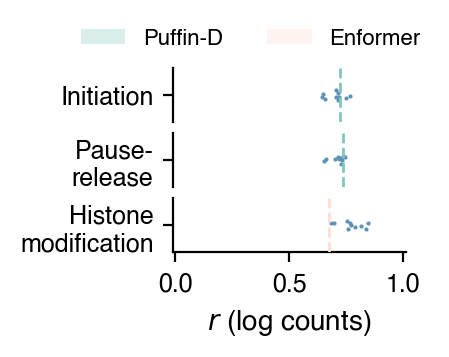

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(1.5, 1.2), sharex=True)

for i, level in enumerate(("Initiation", "Pause-release", "Histone modification")):
    ax = axs[i]
    # plot evaluation results for the deconvoluted tracks
    data = eval_df.loc[eval_df["data type"] == level].copy()
    data.replace({"Pause-release": "Pause-\nrelease", "Histone modification": "Histone\nmodification"}, inplace=True)
    print(level, "DeepDETAILS", data["Overall"].median())
    sns.stripplot(
        x="Overall", y="data type", data=data, 
        ax=ax, s=1.5, color="#5E93B6", edgecolor="#B5E5F3")

    # plot expected bounds
    ref_values = ref_df.loc[(ref_df["data type"] == level) & (ref_df["ref type"] == "Supervised learning"), "Corr coef"].values
    if level == "Histone modification":
        c = "#ffddd2"
    else:
        c = "#83c5be"
    print(level, "Reference", np.median(ref_values))
    ax.axvline(np.mean(ref_values), lw=1, ls="--", zorder=10, color=c)
    
    ax.set_xlim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel("")

    if i < 2:
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(axis='x', bottom=False)
    else:
        ax.set_xlabel(r"$r$ (log counts)")

pd_patch = mpatches.Patch(color='#83c5be', alpha=0.3, label="Puffin-D", lw=0)
ef_patch = mpatches.Patch(color='#ffddd2', alpha=0.3, label="Enformer", lw=0)

fig.legend(handles=[pd_patch, ef_patch], loc='center left', bbox_to_anchor=(-0.25, 1.), ncol=2)